In [ ]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

data = fetch_openml('mnist_784', version=1)#Get data from https://www.openml.org/d/554
dfData = pd.DataFrame(np.c_[data["data"],data["target"]],columns = data["feature_names"]+["target"])
stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in stratSplit.split(dfData[data["feature_names"]], dfData["target"]):
    X_train = dfData[data["feature_names"]].iloc[train_index]
    X_test = dfData[data["feature_names"]].iloc[test_index]

    y_train = dfData["target"].iloc[train_index]
    y_test = dfData["target"].iloc[test_index]

In [ ]:
from sklearn.decomposition import NMF

nnmf = NMF(n_components=100, #number of dimensions/components we gonna dive into (additional shape of our 2 matrices W and H)
           init=None, # matrix initialization method, can heavily impact fitting time (best leave this as the default parameter)
           solver='cd', # optimization procedure, cd = coordinate descent, alt: mu = multiplative updating
           shuffle=True, # shuffle cd coordinate orders, useful for random orders
           beta_loss='frobenius', # loss function to use
                           # https://scikit-learn.org/stable/modules/decomposition.html#nmf-with-a-beta-divergence
           tol=1e-4,
           max_iter=200,
           #alpha=0, # regularization parameter NOT WORKING GIVES AN ERROR
           l1_ratio=0,
           random_state=0, # if initialization contains random component as well as for cd
           verbose=False
         )
X_train_transf = nnmf.fit_transform(X_train) # W matrix, training set
X_test_transf = nnmf.transform(X_test)# W' matrix, testing set

In [ ]:
#looking at the attributes
print(nnmf.components_.shape) # H matix
print(nnmf.reconstruction_err_) # metric based on beta_loss metricc
print(nnmf.n_iter_) #number of training iterations that we've used

In [ ]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
plt.imshow(X_train.astype(float).values[0].reshape(28,28),cmap=plt.get_cmap('gray_r'))
plt.title('Original Image')
plt.axis('off')
ax = fig.add_subplot(122)
X_rec = nnmf.inverse_transform(X_train_transf)
plt.imshow(X_rec[0].reshape(28,-1),cmap=plt.get_cmap('gray_r'))
plt.title('Reconstructed image')
plt.axis('off')
plt.show()

#result:
#good reconstruction on the right hand side (strong similarity to the original on the left hand side)

In [ ]:
#now trying to improve performance and training time

# Exploring performance and training time trade-offs with dimensionality reduction
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.decomposition import NMF  # Replace with other methods as needed

def transform_data(X_train, X_test, method):
    """
    Transforms the data using the specified method and returns the transformed data,
    original data, and the method object.

    Args:
        X_train (numpy array): Training data.
        X_test (numpy array): Test data.
        method (object): Object representing the dimension reduction technique.

    Returns:
        tuple: (X_train_transf, X_test_transf, method)
            - X_train_transf: Transformed training data.
            - X_test_transf: Transformed test data.
            - method: The dimension reduction method object.
    """

    X_train_transf = method.fit_transform(X_train)
    X_test_transf = method.transform(X_test)
    return X_train_transf, X_test_transf, method

def fit_and_visualize(X_train, y_train, X_test, y_test, X_train_transf, X_test_transf, method):
    """
    Trains two random forest classifiers, one on the original data and another
    on the transformed data. Measures and visualizes their performance and feature importance.

    Args:
        X_train (numpy array): Training data.
        y_train (numpy array): Training labels.
        X_test (numpy array): Test data.
        y_test (numpy array): Test labels.
        X_train_transf (numpy array): Transformed training data.
        X_test_transf (numpy array): Transformed test data.
        method (object): The dimension reduction method object.
    """

    rf_clf = RandomForestClassifier(random_state=0)
    rc_clf_red = RandomForestClassifier(random_state=0)

    # Measure training time for original data classifier
    start = time.time()
    rf_clf.fit(X_train, y_train)
    rc_fit_time = time.time() - start

    # Measure training time for classifier on transformed data
    start = time.time()
    rc_clf_red.fit(X_train_transf, y_train)
    rc_red_fit_time = time.time() - start

    # Create visualizations of feature importance
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Original data importance
    ax1.imshow(rf_clf.feature_importances_.reshape(28, 28), cmap=plt.get_cmap('gray_r'))
    ax1.set_title('Original feature importance\nAccuracy: {} Fit time: {:.2f}s'.format(
        round(rf_clf.score(X_test, y_test), 3), rc_fit_time))
    ax1.axis('off')

    # Reconstructed importance (transformed data)
    rc_clf_feat_rec = method.inverse_transform(rc_clf_red.feature_importances_)
    ax2.imshow(rc_clf_feat_rec.reshape(28, -1), cmap=plt.get_cmap('gray_r'))
    ax2.set_title('Reconstructed feature importance\nAccuracy: {} Fit time: {:.2f}s'.format(
        round(rc_clf_red.score(X_test_transf, y_test), 3), rc_red_fit_time))
    ax2.axis('off')

    plt.show()

# Example usage: Transform data with NMF (100 dimensions) and visualize results
X_train_transf, X_test_transf, method = transform_data(X_train, X_test, NMF(n_components=100))
fit_and_visualize(X_train, y_train, X_test, y_test, X_train_transf, X_test_transf, method)

# Adapt as needed:
# - Replace NMF with other dimension reduction techniques.
# - Tune the number of components based on your dataset and task.
# - Consider alternative performance metrics and visualizations.


#result:
#half of the training time for the reconstruction, bad accuracy but excellent reconstruction
#(better/sharper than the original) but it can also be worse according to random runs

---------

In [2]:
from sklearn.datasets import load_boston
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import pandas as pd

data = load_boston()
data.keys()

X, y = data["data"], data["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipe = Pipeline([('std_scl',StandardScaler())
                ])
X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

# note features are not all guaranteed non-negative
for i in range(X_train.shape[1]):
    if X_train[:, i].min()<0:
        X_train[:, i] += -1*X_train[:, i].min()

for i in range(X_test.shape[1]):
    if X_test[:, i].min()<0:
        X_test[:, i] += -1*X_test[:, i].min()


#putting features into a pandas data frame
X_train = pd.DataFrame(X_train,columns=data["feature_names"])
X_test = pd.DataFrame(X_test,columns=data["feature_names"])
y_train = pd.DataFrame(y_train,columns=["target"])
y_test = pd.DataFrame(y_test,columns=["target"])

/home/simon/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing da

standard ridge score: 0.58
Dim. red. ridge score: 0.215


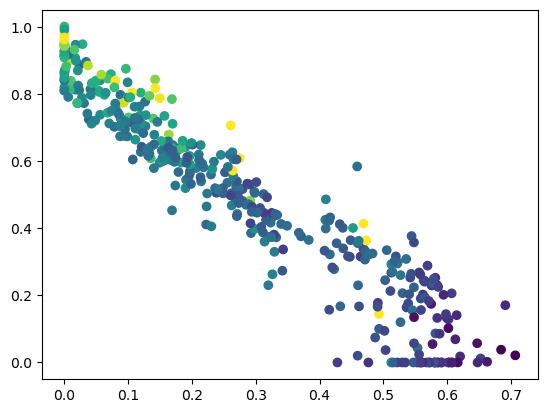

In [5]:
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

nnmf = NMF(n_components=2) #only 2 components: makes it easier for visualization (origianl feature dimensions of the boston set: 13)
X_train_transf = nnmf.fit_transform(X_train)
X_test_transf = nnmf.transform(X_test)

#Ridge Regression
ridge = Ridge()
ridge_red = Ridge()
ridge.fit(X_train, y_train) #original data set
ridge_red.fit(X_train_transf, y_train) #transformed data set
print('standard ridge score:', round(ridge.score(X_test, y_test),3))
print('Dim. red. ridge score:', round(ridge_red.score(X_test_transf, y_test),3))
plt.scatter(X_train_transf[:, 0], X_train_transf[:, 1],c=y_train['target'])
plt.show()

#result:
#some messiness going on but we do see some sort of trend
#why projecting only 2 dimensions? - hard to visualize more than 3 dimensions
#scores: R² scores
#do optimizations to find the right number of dimensions to find a good balance between performance and computation time